# Flood Prediction Factors

**Neccesary Links**
- [MLFlow UI](https://dagshub.com/SantanuK/Kaggle-Competitions-Lab.mlflow/#/experiments/3?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All+Runs&datasetsFilter=W10%3D)

In [1]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name
kaggle_username = 'Kaggle_Username'     # @param ['Kaggle_Username', 'kaggle_username', 'kaggle_2']
kaggle_token = "Kaggle"     # @param ["Kaggle", 'kaggle', 'kaggle_2_pass']

project_name = 'playground-series-s4e5'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
import os
token = {"username":userdata.get(kaggle_username),"key":userdata.get(kaggle_token)}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip $project_name && rm $project_name
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [2]:
import sys
!{sys.executable} -m pip install -U ydata-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension
!pip install optuna-dashboard optuna
!pip install mlflow dagshub shap
!pip install catboost
!mkdir -p output/models
!mkdir -p output/data
!mkdir -p output/html
!pip install --upgrade gdown
display.clear_output()

In [4]:
import dagshub, mlflow, optuna
dagshub.init("Kaggle-Competitions-Lab", "SantanuK", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=7bb0dd61-16cb-4e4f-8e63-5a76589caaca&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=091913f81267b1d0eaa2359132dcdbb81dc871c339e22dcfb0ec5af79ea6ee4a




Initialized MLflow to track repo "SantanuK/Kaggle-Competitions-Lab"

Repository SantanuK/Kaggle-Competitions-Lab initialized!

In [5]:
import shap
shap.initjs()
shap.plots.initjs()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

In [7]:
# plotly libraries setup
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"
pd.set_option('display.max_columns', None)
# import plotly.offline as pyo
# pyo.init_notebook_mode()

In [8]:
experiment_name = 'Flood Prediction Factors'
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    mlflow.set_experiment(experiment_name)
    # print("Experiment has been created or some issue occured!\n","Error: ", e )

In [9]:
from sklearn.metrics import (r2_score)
# 'neg_root_mean_squared_log_error'
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import VALID_METRICS

from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              BaggingRegressor, RandomForestRegressor,
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor
                              )
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

In [10]:
!kaggle datasets download brijlaldhankour/flood-prediction-factors && unzip *.zip && rm -d *.zip

Dataset URL: https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors
License(s): MIT
  0% 0.00/680k [00:00<?, ?B/s]
100% 680k/680k [00:00<00:00, 64.2MB/s]
Archive:  flood-prediction-factors.zip
  inflating: flood.csv               


In [21]:
## Script written to make faster run
num_features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors',]

target_feature = 'FloodProbability'

df_train = pd.read_csv("train.csv").drop('id', axis=1)
df_test = pd.read_csv("test.csv").drop('id', axis=1)
df_extra = pd.read_csv("flood.csv")

def add_features(dataframe):
    df = dataframe.copy()
    df['total'] = df[num_features].sum(axis=1)
    df['mean'] = df[num_features].mean(axis=1)
    df['std'] = df[num_features].std(axis=1)
    df['max'] = df[num_features].max(axis=1)
    df['min'] = df[num_features].min(axis=1)
    df['median'] = df[num_features].median(axis=1)
    df['ptp'] = df[num_features].values.ptp(axis=1)
    df['q25'] = df[num_features].quantile(0.25, axis=1)
    df['q75'] = df[num_features].quantile(0.75, axis=1)
    df['skew'] = df[num_features].skew(axis=1)
    df['kurtosis'] = df[num_features].kurtosis(axis=1)

    # River effect
    df['RiverFactorsNegative'] = df['RiverManagement'] + df['DamsQuality']
    df['RiverFactorsPositive'] = df['Siltation'] + df['Landslides']

    # Weak soil causes flood
    df['SoilQualityPositive'] = df['Deforestation'] + df['AgriculturalPractices'] + df['Watersheds'] + df['WetlandLoss']

    # Management
    df['ManagementNegative'] = df['RiverManagement'] + df['DrainageSystems'] + df['TopographyDrainage']
    df['ManagementPositive'] = df['IneffectiveDisasterPreparedness'] + df['DeterioratingInfrastructure'] + df['InadequatePlanning']

    df['HumanFactors'] = df['PopulationScore'] + df['PoliticalFactors']

    df['ClimateImpact'] = df['MonsoonIntensity'] + df['ClimateChange']
    df['AnthropogenicPressure'] = df['Deforestation'] + df['Urbanization'] + df['AgriculturalPractices'] + df['Encroachments']
    df['InfrastructureQuality'] = df['DamsQuality'] + df['DrainageSystems'] + df['DeterioratingInfrastructure']
    df['CoastalVulnerabilityTotal'] = df['CoastalVulnerability'] + df['Landslides']
    df['PreventiveMeasuresEfficiency'] = df['RiverManagement'] + df['IneffectiveDisasterPreparedness'] + df['InadequatePlanning']
    df['EcosystemImpact'] = df['WetlandLoss'] + df['Watersheds']
    df['SocioPoliticalContext'] = df['PopulationScore'] * df['PoliticalFactors']
    try:
        df = df.drop(target_feature, axis=1)
        df[target_feature] = dataframe[target_feature]
    except Exception as e:
        pass
    return df

combined = pd.concat([train, extra]).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(combined.drop(target_feature, axis=1),
                                                    combined[target_feature], test_size=.3, random_state=657)
def calc_score(model):
    return (r2_score(y_train, model.predict(X_train)),
    r2_score(y_test, model.predict(X_test)),
    r2_score(extra[target_feature], model.predict(extra.drop(target_feature,axis=1))))

def append_study(study):
    res_ = {
        'trial_id'      : [],
        'test_score'    : [],
        'margin'        : [],
        'params'        : [],
        'original_score': [],
    }
    for trial in study.best_trials:
        res_['trial_id'].append(trial.number)
        res_['params'].append(trial.params)
        res_['test_score'].append(trial.values[0])
        res_['margin'].append(trial.values[1])
        res_['original_score'].append(trial.values[2])

    result_df = pd.DataFrame(res_)
    select_cols = ['trial_id', 'train_score', 'test_score', 'original_score', 'margin', 'params']
    result_df['train_score'] = result_df['test_score'] - result_df['margin']
    result_df = result_df[select_cols]
    return result_df



## Dataset loading

In [12]:
df_train = pd.read_csv("train.csv").drop('id', axis=1)
df_test = pd.read_csv("test.csv").drop('id', axis=1)
df_extra = pd.read_csv("flood.csv")

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(df_extra, title="Profiling Report")
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
profile.to_file("output/html/extra.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning:

Try running command: 'pip install --upgrade Pillow' to avoid ValueError



Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [ ]:
df_train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null 

In [ ]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


In [ ]:
features = df_test.columns
def visualization(dataframe, features=features):
    summary = {
        'Columns'   :   [],
        'Count'     :   [],
        'Unique count': [],
        'Max'       :   [],
        'Min'       :   [],
        'Mean'      :   [],
        'Std'       :   [],
        '5%'        :   [],
        '25%'        :   [],
        '50%'        :   [],
        '75%'        :   [],
        '95%'        :   [],
        # IQR, Low Bound, High Bound
        'IQR'       :   [],
        'Low Bound' :   [],
        'High Bound':   [],
        '< Low Bound' :   [],
        '> High Bound':   [],
        'Outliers'  : [],
        '% Outliers'  : [],
    }
    for col in features:
        summary['Columns'].append(col)
        summary['Count'].append(dataframe[col].notnull().sum())
        summary['Unique count'].append(dataframe[col].nunique())
        summary['Max'].append(dataframe[col].max())
        summary['Min'].append(dataframe[col].min())
        summary['Mean'].append(dataframe[col].mean())
        summary['Std'].append(dataframe[col].std())
        for num in [5, 25, 50, 75, 95]:
            summary[f"{num}%"].append(np.percentile(dataframe[col], num))
        summary['IQR'].append(summary['75%'][-1] - summary['25%'][-1])
        summary['Low Bound'].append(summary['50%'][-1]-1.5*summary['IQR'][-1])
        summary['High Bound'].append(summary['50%'][-1]+1.5*summary['IQR'][-1])

        summary["< Low Bound"].append(len(dataframe[dataframe[col]<summary["Low Bound"][-1]]))
        summary["> High Bound"].append(len(dataframe[dataframe[col]>summary["High Bound"][-1]]))
        summary["Outliers"].append(summary["< Low Bound"][-1]+ summary["> High Bound"][-1])
        summary["% Outliers"].append(summary["Outliers"][-1]/len(dataframe)*100.0)
    summary = pd.DataFrame(summary)

    return summary



In [ ]:
visualization(df_train)

,Columns,Count,Unique count,Max,Min,Mean,Std,5%,25%,50%,75%,95%,IQR,Low Bound,High Bound,< Low Bound,> High Bound,Outliers,% Outliers
0,MonsoonIntensity,1117957,17,16,0,4.921450,2.056387,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,5431,23284,28715,2.568525
1,TopographyDrainage,1117957,19,18,0,4.926671,2.093879,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,5541,25099,30640,2.740714
2,RiverManagement,1117957,17,16,0,4.955322,2.072186,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,34279,60442,94721,8.472687
3,Deforestation,1117957,18,17,0,4.942240,2.051689,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,32208,57493,89701,8.023654
4,Urbanization,1117957,18,17,0,4.942517,2.083391,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,5350,24874,30224,2.703503
5,ClimateChange,1117957,18,17,0,4.934093,2.057742,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,5347,23159,28506,2.549830
6,DamsQuality,1117957,17,16,0,4.955878,2.083063,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,34483,61122,95605,8.551760
7,Siltation,1117957,17,16,0,4.927791,2.065992,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,5381,23894,29275,2.618616
8,AgriculturalPractices,1117957,17,16,0,4.942619,2.068545,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,5680,23628,29308,2.621568
9,Encroachments,1117957,19,18,0,4.949230,2.083324,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,33510,62922,96432,8.625734


In [ ]:
visualization(df_test)

,Columns,Count,Unique count,Max,Min,Mean,Std,5%,25%,50%,75%,95%,IQR,Low Bound,High Bound,< Low Bound,> High Bound,Outliers,% Outliers
0,MonsoonIntensity,745305,17,16,0,4.915610,2.056295,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,3746,15421,19167,2.571699
1,TopographyDrainage,745305,18,17,0,4.930288,2.094117,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,3713,16768,20481,2.748002
2,RiverManagement,745305,17,16,0,4.960027,2.071722,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,22956,40455,63411,8.508060
3,Deforestation,745305,18,17,0,4.946084,2.052602,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,21356,38440,59796,8.023024
4,Urbanization,745305,18,17,0,4.938424,2.081816,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,3636,16603,20239,2.715533
5,ClimateChange,745305,18,17,0,4.933524,2.059243,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,3466,15404,18870,2.531849
6,DamsQuality,745305,17,16,0,4.958468,2.089312,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,23265,41221,64486,8.652297
7,Siltation,745305,17,16,0,4.927651,2.068110,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,3537,15876,19413,2.604705
8,AgriculturalPractices,745305,17,16,0,4.945308,2.073404,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,3858,15945,19803,2.657033
9,Encroachments,745305,18,17,0,4.950620,2.081750,2.0,4.0,5.0,6.0,9.0,2.0,2.0,8.0,22459,41772,64231,8.618083


In [ ]:
visualization(df_extra)

,Columns,Count,Unique count,Max,Min,Mean,Std,5%,25%,50%,75%,95%,IQR,Low Bound,High Bound,< Low Bound,> High Bound,Outliers,% Outliers
0,MonsoonIntensity,50000,17,16,0,4.99148,2.236834,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,332,1571,1903,3.806
1,TopographyDrainage,50000,18,18,0,4.98410,2.246488,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,333,1637,1970,3.940
2,RiverManagement,50000,17,16,0,5.01594,2.231310,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,335,1588,1923,3.846
3,Deforestation,50000,18,17,0,5.00848,2.222743,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,328,1534,1862,3.724
4,Urbanization,50000,18,17,0,4.98906,2.243159,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,331,1625,1956,3.912
5,ClimateChange,50000,18,17,0,4.98834,2.226761,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,326,1525,1851,3.702
6,DamsQuality,50000,17,16,0,5.01536,2.245000,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,352,1655,2007,4.014
7,Siltation,50000,17,16,0,4.98860,2.232642,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,312,1556,1868,3.736
8,AgriculturalPractices,50000,17,16,0,5.00612,2.234588,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,350,1567,1917,3.834
9,Encroachments,50000,18,18,0,5.00638,2.241633,2.0,3.0,5.0,6.0,9.0,3.0,0.5,9.5,340,1631,1971,3.942


In [ ]:
target = 'FloodProbability'
summary = {
    'Columns' : [],
    'Train count' : [],
    'Original count' : [],
    'Test count' : [],
    # Experimental
    # 'Linear factor': [],
    # 'Linear bias'  : [],
    # 'Linear score' : [],
}
for col in df_test.columns:
    summary['Columns'].append(col)
    summary['Train count'].append(df_train[col].nunique())
    summary['Original count'].append(df_extra[col].nunique())
    summary['Test count'].append(df_test[col].nunique())


# Experimental

# for col in df_test.columns:
#     lr = LinearRegression()
#     lr.fit(df_extra[[col]], df_extra[target])
#     summary['Linear factor'].append(lr.coef_[0])
#     summary['Linear bias'].append(lr.intercept_)
#     summary['Linear score'].append(lr.score(df_extra[[col]], df_extra[target]))
summary = pd.DataFrame(summary)
summary

,Columns,Train count,Original count,Test count,Linear factor,Linear bias,Linear score
0,MonsoonIntensity,17,17,17,0.005012,0.474641,0.050212
1,TopographyDrainage,19,18,18,0.005110,0.474194,0.052631
2,RiverManagement,17,17,17,0.005133,0.473913,0.052403
3,Deforestation,18,18,18,0.004958,0.474830,0.048504
4,Urbanization,18,18,18,0.004927,0.475082,0.048782
5,ClimateChange,18,18,18,0.004965,0.474891,0.048835
6,DamsQuality,17,17,17,0.005070,0.474235,0.051741
7,Siltation,17,17,17,0.005077,0.474334,0.051322
8,AgriculturalPractices,17,17,17,0.004967,0.474793,0.049216
9,Encroachments,19,18,18,0.004872,0.475271,0.047637


In [ ]:
summary = {
    'Columns' : [],
    'Train count' : [],
    'Original count' : [],
    'Test count' : [],
}
stringfy = lambda x,y: ",".join(map(str, np.sort(x[y].unique())))
for col in df_test.columns:
    summary['Columns'].append(col)
    summary['Train count'].append(stringfy(df_train, col))
    summary['Original count'].append(stringfy(df_extra, col))
    summary['Test count'].append(stringfy(df_test, col))
summary = pd.DataFrame(summary)
summary

In [ ]:
"""
There is a discrepency in WetlandLoss, PopulationScore.
"""
df_train['WetlandLoss'].value_counts()

In [ ]:
df_train['PopulationScore'].value_counts()

In [ ]:
num_features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors',]

target_feature = 'FloodProbability'

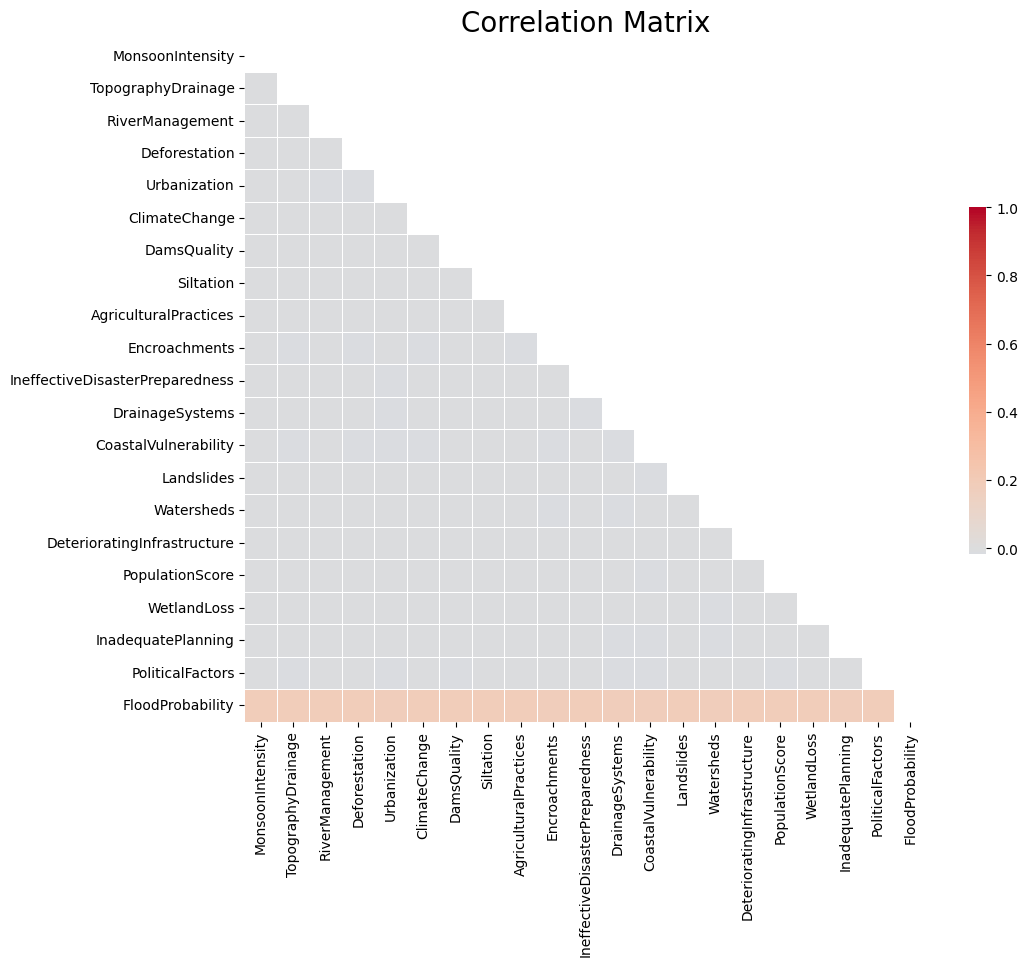

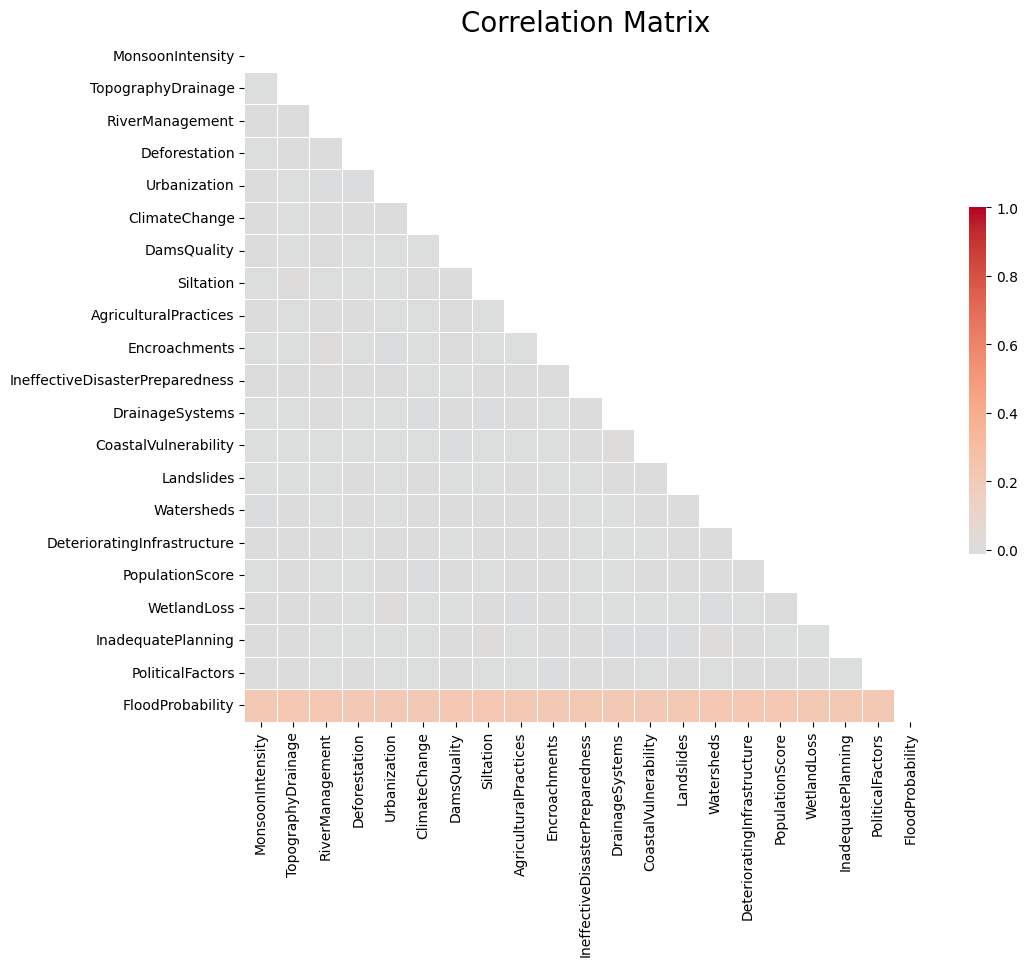

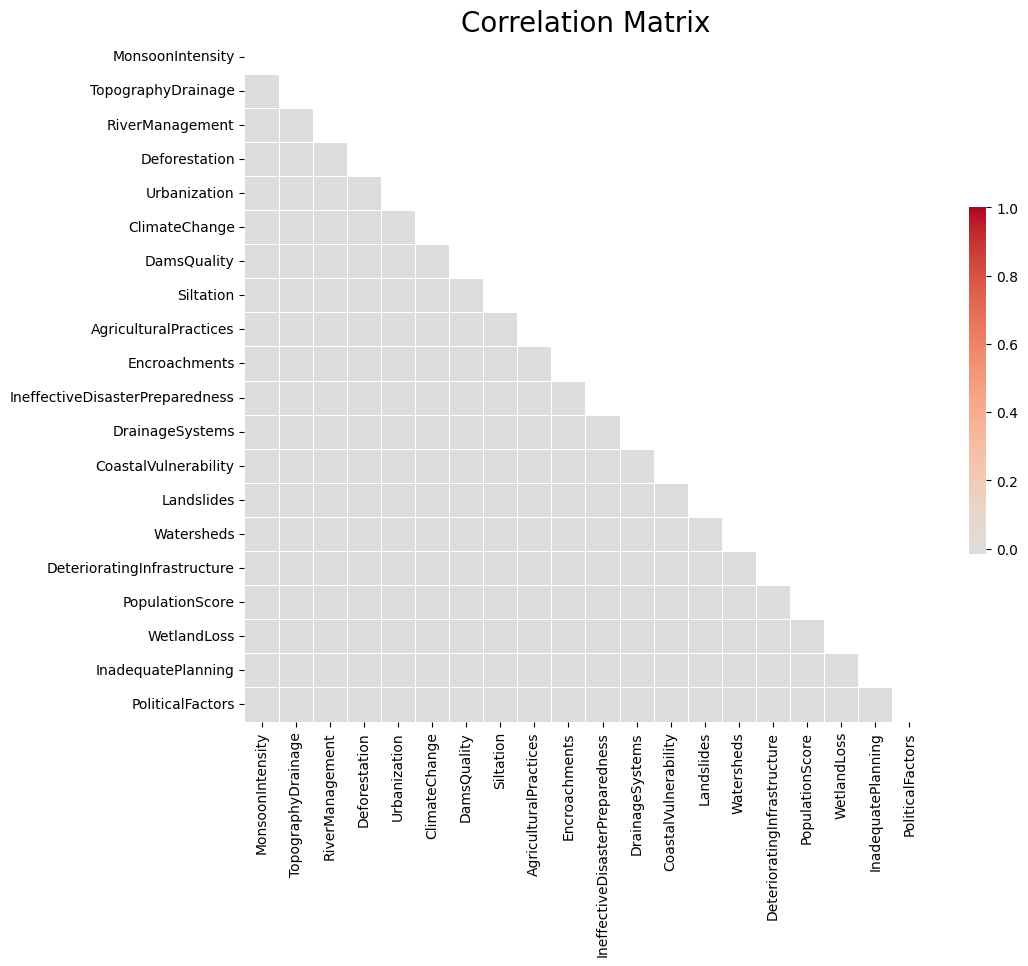

In [ ]:
for i, df in enumerate([df_train, df_extra, df_test]):
    try:
        corr = df[num_features+[target_feature,]].corr()
    except KeyError as e:
        corr = df[num_features].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title('Correlation Matrix', fontsize=20)
    !mkdir -p output/images
    plt.savefig(f"output/images/Correlation matrix_{i+1}.png")
    plt.show()

## Feature selection

Sure, here's a tabular representation indicating the potential positive or negative relationship of each numerical feature with flood probability, along with associated tags:

| Feature                       | Relationship with Flood Probability | Tags                                      |
|-------------------------------|-------------------------------------|-------------------------------------------|
| MonsoonIntensity              | Positive                            | Rainfall, Weather                         |
| TopographyDrainage            | Negative                            | Terrain, Landforms, Drainage Systems      |
| RiverManagement               | Negative                            | Water Management, Infrastructure         |
| Deforestation                 | Positive                            | Environmental Degradation, Land Use       |
| Urbanization                  | Positive                            | Population Density, Infrastructure        |
| ClimateChange                 | Positive                            | Weather Patterns, Environmental Change    |
| DamsQuality                   | Negative                            | Infrastructure, Water Management          |
| Siltation                     | Negative                            | Sedimentation, River Health               |
| AgriculturalPractices         | Both Positive and Negative          | Land Use, Farming Practices               |
| Encroachments                 | Positive                            | Land Use, Urbanization                    |
| IneffectiveDisasterPreparedness | Positive                          | Governance, Emergency Response            |
| DrainageSystems               | Negative                            | Infrastructure, Urban Planning            |
| CoastalVulnerability          | Positive                            | Sea Level Rise, Coastal Management        |
| Landslides                    | Positive                            | Geology, Terrain Stability                |
| Watersheds                    | Negative                            | Hydrology, Soil                           |
| DeterioratingInfrastructure   | Positive                            | Infrastructure, Maintenance              |
| PopulationScore               | Positive                            | Population Density, Urbanization          |
| WetlandLoss                   | Positive                            | Environmental Degradation, Biodiversity   |
| InadequatePlanning            | Positive                            | Governance, Urban Planning                |
| PoliticalFactors              | Both Positive and Negative          | Governance, Policy                        |

This table provides a brief overview of the potential impact of each feature on flood probability along with associated tags that highlight the key themes or aspects related to each feature.

In [13]:
num_features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors',]

target_feature = 'FloodProbability'

In [14]:
def add_features(dataframe):
    df = dataframe.copy()
    df['total'] = df[num_features].sum(axis=1)
    df['mean'] = df[num_features].mean(axis=1)
    df['std'] = df[num_features].std(axis=1)
    df['max'] = df[num_features].max(axis=1)
    df['min'] = df[num_features].min(axis=1)
    df['median'] = df[num_features].median(axis=1)
    df['ptp'] = df[num_features].values.ptp(axis=1)
    df['q25'] = df[num_features].quantile(0.25, axis=1)
    df['q75'] = df[num_features].quantile(0.75, axis=1)
    df['skew'] = df[num_features].skew(axis=1)
    df['kurtosis'] = df[num_features].kurtosis(axis=1)

    # River effect
    df['RiverFactorsNegative'] = df['RiverManagement'] + df['DamsQuality']
    df['RiverFactorsPositive'] = df['Siltation'] + df['Landslides']

    # Weak soil causes flood
    df['SoilQualityPositive'] = df['Deforestation'] + df['AgriculturalPractices'] + df['Watersheds'] + df['WetlandLoss']

    # Management
    df['ManagementNegative'] = df['RiverManagement'] + df['DrainageSystems'] + df['TopographyDrainage']
    df['ManagementPositive'] = df['IneffectiveDisasterPreparedness'] + df['DeterioratingInfrastructure'] + df['InadequatePlanning']

    df['HumanFactors'] = df['PopulationScore'] + df['PoliticalFactors']

    df['ClimateImpact'] = df['MonsoonIntensity'] + df['ClimateChange']
    df['AnthropogenicPressure'] = df['Deforestation'] + df['Urbanization'] + df['AgriculturalPractices'] + df['Encroachments']
    df['InfrastructureQuality'] = df['DamsQuality'] + df['DrainageSystems'] + df['DeterioratingInfrastructure']
    df['CoastalVulnerabilityTotal'] = df['CoastalVulnerability'] + df['Landslides']
    df['PreventiveMeasuresEfficiency'] = df['RiverManagement'] + df['IneffectiveDisasterPreparedness'] + df['InadequatePlanning']
    df['EcosystemImpact'] = df['WetlandLoss'] + df['Watersheds']
    df['SocioPoliticalContext'] = df['PopulationScore'] * df['PoliticalFactors']
    try:
        df = df.drop(target_feature, axis=1)
        df[target_feature] = dataframe[target_feature]
    except Exception as e:
        pass
    return df


In [ ]:
train = add_features(df_train)
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,total,mean,std,max,min,median,ptp,q25,q75,skew,kurtosis,RiverFactorsNegative,RiverFactorsPositive,SoilQualityPositive,ManagementNegative,ManagementPositive,HumanFactors,ClimateImpact,AnthropogenicPressure,InfrastructureQuality,CoastalVulnerabilityTotal,PreventiveMeasuresEfficiency,EcosystemImpact,SocioPoliticalContext,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,94,4.70,1.750188,8,2,4.5,6,3.00,5.25,0.577258,-0.521862,9,6,21,18,13,10,9,21,13,6,14,10,21,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,94,4.70,2.296450,9,0,4.0,9,3.00,6.25,0.148339,-0.358403,7,5,14,18,18,6,14,22,15,2,17,6,9,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,99,4.95,1.932411,8,1,5.0,7,3.00,6.25,-0.408083,-0.742415,7,12,18,18,15,11,13,19,14,10,15,7,24,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,104,5.20,1.641565,8,2,5.0,6,4.00,6.25,0.120566,-0.590749,10,14,20,12,16,11,11,23,10,11,18,9,30,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,72,3.60,1.500877,6,1,3.0,5,2.75,5.00,0.253227,-0.922261,5,9,17,7,12,6,9,16,9,8,10,8,5,0.415


In [ ]:
train.shape

(1117957, 45)

## Training a model

In [ ]:
def select_model(dataframe, test_size=.3, target_feature=target_feature, model = None):
    !mkdir -p output/data
    algos = [
            #  SVC(), NuSVC(),
            #  LinearRegression(),
            DecisionTreeRegressor(), ExtraTreeRegressor(),
            AdaBoostRegressor(), BaggingRegressor(),
            # ExtraTreesRegressor(),
            # RandomForestRegressor(),
            GradientBoostingRegressor(),
            HistGradientBoostingRegressor(),
            LGBMRegressor(verbose=-1), XGBRegressor(), XGBRFRegressor(),
            CatBoostRegressor(verbose=0)
            ]
    names = list(map(lambda x: x.__class__.__name__, algos))

    history = { 'algo_name': names,
                'train_score' : [],
                'test_score' : [],
                # 'Min_1': [],
                # 'Min_2': [],
                # 'train_metrics': [],
                # 'test_metrics': [],
                }
    X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(target_feature, axis=1), dataframe[target_feature], test_size=test_size)
    for model in algos:
        print(f"{model.__class__.__name__} has started!")
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        history['train_score'].append(r2_score(y_train, pred_train))
        history['test_score'].append(r2_score(y_test, pred_test))
        """
        try:
            # history['Min_1'].append(np.min(pred_train))
            # history['Min_2'].append(np.min(pred_test))

            history['train_metrics'].append(RMLE(y_train, pred_train))
            history['test_metrics'].append(RMLE(y_test, pred_test))
        except Exception as e:
            # history['Min_1'].append(np.nan)
            # history['Min_2'].append(np.nan)
            history['train_metrics'].append(np.nan)
            history['test_metrics'].append(np.nan)
            """
    clear_output()
    return pd.DataFrame(history)

In [ ]:
x = select_model(df_train)
x

,algo_name,train_score,test_score
0,DecisionTreeRegressor,1.000000,0.051597
1,ExtraTreeRegressor,1.000000,-0.021620
2,AdaBoostRegressor,0.517073,0.517072
3,BaggingRegressor,0.922572,0.596314
4,GradientBoostingRegressor,0.616597,0.614131
5,HistGradientBoostingRegressor,0.772580,0.765711
6,LGBMRegressor,0.772555,0.765696
7,XGBRegressor,0.818060,0.808536
8,XGBRFRegressor,0.218205,0.213050
9,CatBoostRegressor,0.849483,0.846087


In [ ]:
y = select_model(train)
y

,algo_name,train_score,test_score
0,DecisionTreeRegressor,1.000000,0.728471
1,ExtraTreeRegressor,1.000000,0.728679
2,AdaBoostRegressor,0.428918,0.421553
3,BaggingRegressor,0.973977,0.853459
4,GradientBoostingRegressor,0.867141,0.866472
5,HistGradientBoostingRegressor,0.869208,0.868231
6,LGBMRegressor,0.869738,0.868355
7,XGBRegressor,0.872064,0.868158
8,XGBRFRegressor,0.866756,0.866123
9,CatBoostRegressor,0.871713,0.868369


In [ ]:
y['Diff'] = y['train_score']-y['test_score']
y

,algo_name,train_score,test_score,Diff
0,DecisionTreeRegressor,1.000000,0.728471,0.271529
1,ExtraTreeRegressor,1.000000,0.728679,0.271321
2,AdaBoostRegressor,0.428918,0.421553,0.007365
3,BaggingRegressor,0.973977,0.853459,0.120518
4,GradientBoostingRegressor,0.867141,0.866472,0.000669
5,HistGradientBoostingRegressor,0.869208,0.868231,0.000977
6,LGBMRegressor,0.869738,0.868355,0.001383
7,XGBRegressor,0.872064,0.868158,0.003906
8,XGBRFRegressor,0.866756,0.866123,0.000633
9,CatBoostRegressor,0.871713,0.868369,0.003344


## Training Base Model

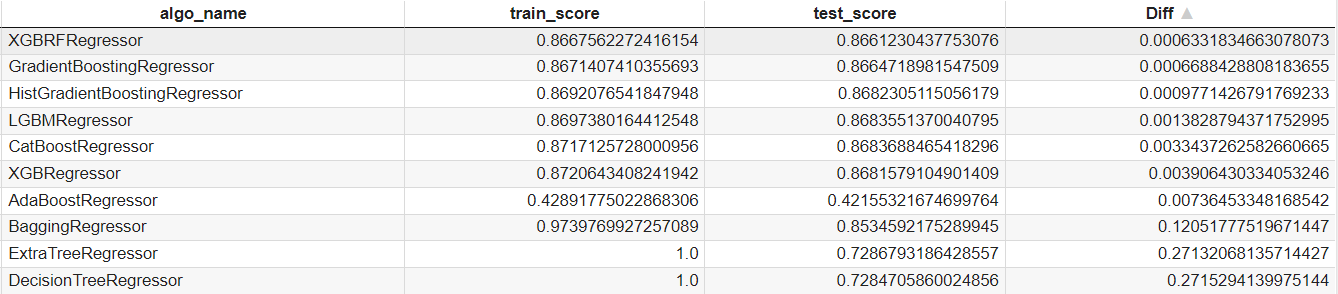

In [15]:
train = add_features(df_train)
test = add_features(df_test)
extra = add_features(df_extra)

X_train, X_test, y_train, y_test = train_test_split(train.drop(target_feature, axis=1),
                                                    train[target_feature], test_size=.3, random_state=657)
def calc_score(model):
    return (r2_score(y_train, model.predict(X_train)),
    r2_score(y_test, model.predict(X_test)),
    r2_score(extra[target_feature], model.predict(extra.drop(target_feature,axis=1))))

### XGBRFRegressor

In [25]:
xgbrf = XGBRFRegressor()
xgbrf.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [ ]:
xgbrf.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
calc_score(xgbrf)

(0.8686126995528863, 0.8680727155884354, 0.9213045088559682)

In [ ]:
# only train
(0.8666150139909652, 0.8668144710135064, 0.907657572351097)
# combined(train+original)
(0.8686126995528863, 0.8680727155884354, 0.9213045088559682)

In [16]:
combined = pd.concat([train, extra]).reset_index(drop=True)

In [18]:
combined.duplicated().sum()

0

In [19]:
X_train, X_test, y_train, y_test = train_test_split(combined.drop(target_feature, axis=1),
                                                    combined[target_feature], test_size=.3, random_state=657)
def calc_score(model):
    return (r2_score(y_train, model.predict(X_train)),
    r2_score(y_test, model.predict(X_test)),
    r2_score(extra[target_feature], model.predict(extra.drop(target_feature,axis=1))))

In [ ]:
def objective(trial):

    params = {
        'max_depth'         : trial.suggest_categorical('max_depth', [3, 4, 5, 6, None]),
        'max_leaves'        : trial.suggest_categorical('max_leaves', [20, 25, 27, 28, 30, None]),
        'grow_policy'       : trial.suggest_categorical('grow_policy', ['depthwise','lossguide', None]),
        'learning_rate'     : trial.suggest_float('learning_rate', .001, 2, log=True),
        'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist', None]),
        'gamma'             : trial.suggest_categorical('gamma',[0, 1e-4, 1e-3, 1e-1, None] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .8, .9, 1.0] ),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .8, .9, 1.0] ),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .4, .5, .67, .75, .8, .9, 1.0] ),
        'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .4, .5, .67, .75, .8, .9, 1.0] ),
        'reg_alpha'         : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'        : trial.suggest_float('reg_lambda', 0, 1),
        'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover', None]),
    }

    model = XGBRFRegressor(**params, n_estimators= 50)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score, score
    except Exception as e:
        return -np.inf, -np.inf, -np.inf

study = optuna.create_study(directions= ['maximize', 'maximize', 'maximize' ], study_name = 'XGBRF_study')
study.optimize(objective, n_trials = 100)

[I 2024-05-11 23:12:01,039] A new study created in memory with name: XGBRF_study
[I 2024-05-11 23:12:21,629] Trial 0 finished with values: [0.08261459739051469, 0.0002235545232411873, 0.09352680430049731] and parameters: {'max_depth': 6, 'max_leaves': 28, 'grow_policy': None, 'learning_rate': 0.07577176817388097, 'tree_method': 'approx', 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.5, 'reg_alpha': 0.038181184128722956, 'reg_lambda': 0.6362373030026768, 'importance_type': 'total_cover'}. 
[I 2024-05-11 23:12:40,830] Trial 1 finished with values: [0.5586182420272809, 0.0003565953006630096, 0.6650491438990922] and parameters: {'max_depth': 6, 'max_leaves': 25, 'grow_policy': 'depthwise', 'learning_rate': 0.452571508973831, 'tree_method': 'approx', 'gamma': 0.1, 'subsample': 0.4, 'colsample_bytree': 0.67, 'colsample_bylevel': 0.67, 'colsample_bynode': 0.67, 'reg_alpha': 0.2941102643435951, 'reg_lambda': 0.3819816355527561, 'importan

In [ ]:
[0.8605735219272455, -0.0004587298085718672, 0.9166876092512444]
parameters= {'max_depth': None, 'max_leaves': 25, 'grow_policy': 'depthwise',
             'learning_rate': 1.1015793272433867, 'tree_method': 'exact',
             'gamma': None, 'subsample': 0.75, 'colsample_bytree': 0.67,
             'colsample_bylevel': 0.67, 'colsample_bynode': 0.5,
             'reg_alpha': 0.11478884221877439, 'reg_lambda': 0.2675149365470445,
             'importance_type': 'total_cover'}
[0.8318856308323704, 9.753780666688083e-05, 0.895114684482293] and
parameters: {'max_depth': 3, 'max_leaves': 25, 'grow_policy': 'lossguide',
             'learning_rate': 1.1015793272433867,
             'tree_method': 'exact', 'gamma': None, 'subsample': 0.75,
             'colsample_bytree': 0.67, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.5,
             'reg_alpha': 0.11478884221877439, 'reg_lambda': 0.4241415596901158, 'importance_type': 'gain'}.

In [20]:
def append_study(study):
    res_ = {
        'trial_id'      : [],
        'test_score'    : [],
        'margin'        : [],
        'params'        : [],
        'original_score': [],
    }
    for trial in study.best_trials:
        res_['trial_id'].append(trial.number)
        res_['params'].append(trial.params)
        res_['test_score'].append(trial.values[0])
        res_['margin'].append(trial.values[1])
        res_['original_score'].append(trial.values[2])

    result_df = pd.DataFrame(res_)
    select_cols = ['trial_id', 'train_score', 'test_score', 'original_score', 'margin', 'params']
    result_df['train_score'] = result_df['test_score'] - result_df['margin']
    result_df = result_df[select_cols]
    return result_df

In [ ]:
[0.6382918443822259, 1.0988811276924082e-05, 0.7725438832037316]
parameters = {'grow_policy': 'lossguide', 'learning_rate': 0.48913839839925044,
              'tree_method': 'approx', 'gamma': 0.1, 'subsample': 1.0,
              'colsample_bytree': 1.0, 'colsample_bylevel': 1.0,
              'colsample_bynode': 0.5, 'reg_alpha': 0.0009518420186215575,
              'reg_lambda': 0.0041620486107782385, 'importance_type': 'gain'}

In [ ]:
params = {'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
          }
params = {'colsample_bynode': 0.8,
 'learning_rate': 1,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
          }

model = XGBRFRegressor(n_estimators= 60,**params)
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=60, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, ...)

In [ ]:
calc_score(model)

(0.8686132195133539, 0.8680823141152818, 0.9214111481815057)

- Default: (0.8686126995528863, 0.8680727155884354, 0.9213045088559682)
- n_estimators= 50: (0.8686155405463981, 0.8680801487411176, 0.921381247350424)

In [ ]:
train_scores = []
diffs = []
scores = []
for n_estimators in range(5,101,5):
    model = XGBRFRegressor(n_estimators= n_estimators,**params)
    model.fit(X_train, y_train)
    a, b, c = calc_score(model)
    train_scores.append(a)
    diffs.append(a-b)
    scores.append(c)


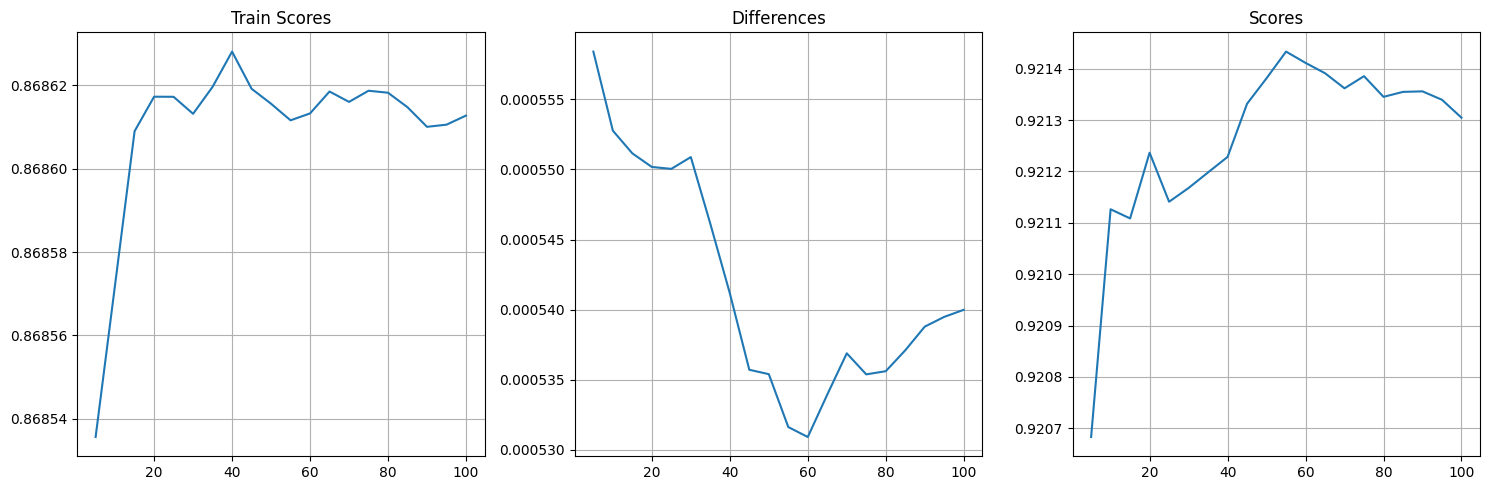

In [ ]:
# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
x = range(5,101,5)
# Plotting on each subplot
axs[0].plot(x, train_scores)
axs[0].set_title('Train Scores')
axs[0].grid()

axs[1].plot(x, diffs)
axs[1].set_title('Differences')
axs[1].grid()

axs[2].plot(x, scores)
axs[2].set_title('Scores')
axs[2].grid()

plt.tight_layout()
plt.show()

#### New Training

In [29]:
def objective(trial):

    params = {
        # 'max_depth'         : trial.suggest_categorical('max_depth', [3, 4, 5, 6, None]),
        # 'max_leaves'        : trial.suggest_categorical('max_leaves', [20, 25, 27, 28, 30, None]),
        # 'grow_policy'       : trial.suggest_categorical('grow_policy', ['depthwise','lossguide', None]),
        'learning_rate'     : trial.suggest_float('learning_rate', 1, 1.1, log=True),
        # 'tree_method'       : trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist', None]),
        # 'gamma'             : trial.suggest_categorical('gamma',[0, 1e-4, 1e-3, 1e-1, None] ),
        'subsample'         : trial.suggest_categorical('subsample',[ .4, .5, .67, .75, .8, .9, 1.0, None] ),
        'colsample_bytree'  : trial.suggest_categorical('colsample_bytree',[ .4, .5, .67, .75, .8, .9, 1.0, None] ),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel',[ .4, .5, .67, .75, .8, .9, 1.0, None] ),
        'colsample_bynode'  : trial.suggest_categorical('colsample_bynode',[ .4, .5, .67, .75, .8, .9, 1.0, None] ),
        'reg_alpha'         : trial.suggest_categorical('reg_alpha', [0, 1e-4, 1e-3, 1e-2, 1e-1]),
        'reg_lambda'        : trial.suggest_categorical('reg_lambda',[0, 1e-4, 1e-3, 1e-2, 1e-1]),
        # 'importance_type'   : trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover', None]),
    }

    model = XGBRFRegressor(**params, n_estimators= 50)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score, score
    except Exception as e:
        return -np.inf, -np.inf, -np.inf

study = optuna.create_study(directions= ['maximize', 'maximize', 'maximize' ], study_name = 'XGBRF_study')
study.optimize(objective, n_trials = 50)

[I 2024-05-13 19:26:37,487] A new study created in memory with name: XGBRF_study
[I 2024-05-13 19:26:55,615] Trial 0 finished with values: [0.8661443867120664, -0.0006050049223692566, 0.8999636928744988] and parameters: {'learning_rate': 1.0493575276518536, 'subsample': 0.75, 'colsample_bytree': 0.8, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'reg_alpha': 0.001, 'reg_lambda': 0.01}. 
[I 2024-05-13 19:27:11,367] Trial 1 finished with values: [0.8655509708685699, -0.0005731494933266523, 0.90432651410519] and parameters: {'learning_rate': 1.0611923879156373, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.9, 'reg_alpha': 0.001, 'reg_lambda': 0.001}. 
[I 2024-05-13 19:27:26,950] Trial 2 finished with values: [0.8452483975448712, -0.00024542950195427515, 0.9322720342981781] and parameters: {'learning_rate': 1.0407948133928537, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.5, 'reg_alpha': 0.0001, 

In [30]:
result_df = append_study(study)

In [31]:
result_df

,trial_id,train_score,test_score,original_score,margin,params
0,2,0.845494,0.845248,0.932272,-0.000245,"{'learning_rate': 1.0407948133928537, 'subsamp..."
1,3,0.865550,0.865122,0.923891,-0.000428,"{'learning_rate': 1.040219591516414, 'subsampl..."
2,5,0.861103,0.860718,0.922373,-0.000386,"{'learning_rate': 1.0882191676200377, 'subsamp..."
3,6,0.845602,0.845257,0.944479,-0.000346,"{'learning_rate': 1.0557277621561962, 'subsamp..."
4,7,0.861800,0.861387,0.904595,-0.000412,"{'learning_rate': 1.0752607375411187, 'subsamp..."
5,10,0.855008,0.854541,0.935476,-0.000467,"{'learning_rate': 1.0792271247260303, 'subsamp..."
6,11,0.848657,0.848226,0.945801,-0.000432,"{'learning_rate': 1.0114582864793744, 'subsamp..."
7,12,0.867825,0.867338,0.922712,-0.000486,"{'learning_rate': 1.0043310361190796, 'subsamp..."
8,13,0.867456,0.866983,0.919043,-0.000473,"{'learning_rate': 1.0274431539703517, 'subsamp..."
9,14,0.867861,0.867357,0.915633,-0.000504,"{'learning_rate': 1.027455668221198, 'subsampl..."


In [ ]:
params = {'learning_rate': 0.9928712851317344, 'subsample': 0.67,
          'colsample_bytree': 1.0, 'colsample_bylevel': 0.9,
          'colsample_bynode': 0.5, 'reg_alpha': 0.26887066291690964,
          'reg_lambda': 0.1536336728569171}

{'learning_rate': 1.0166221707378873, 'subsample': 0.4, 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.9, 'colsample_bynode': 0.9, 'reg_alpha': 0, 'reg_lambda': 0.0001}


In [ ]:
[0.8659483758435454, -0.00041339480132129847, 0.9278350073541733]
parameters = {'learning_rate': 0.9928712851317344,
             'subsample': 0.67, 'colsample_bytree': 1.0,
             'colsample_bylevel': 0.9, 'colsample_bynode': 0.5,
             'reg_alpha': 0.26887066291690964, 'reg_lambda': 0.1536336728569171}

In [28]:
a, b, c = calc_score(xgbrf)
b, b-a, c

(0.8680727155884354, -0.0005399839644509852, 0.9213045088559682)

### CatBoostRegressor

In [32]:
cbc = CatBoostRegressor()
cbc.fit(X_train, y_train)

Learning rate set to 0.11813
0:	learn: 0.0460716	total: 336ms	remaining: 5m 36s
1:	learn: 0.0417819	total: 681ms	remaining: 5m 39s
2:	learn: 0.0380570	total: 1.04s	remaining: 5m 44s
3:	learn: 0.0348656	total: 1.42s	remaining: 5m 52s
4:	learn: 0.0321131	total: 1.77s	remaining: 5m 51s
5:	learn: 0.0297846	total: 2.13s	remaining: 5m 52s
6:	learn: 0.0278194	total: 2.46s	remaining: 5m 49s
7:	learn: 0.0261469	total: 2.8s	remaining: 5m 47s
8:	learn: 0.0247631	total: 3.17s	remaining: 5m 49s
9:	learn: 0.0236163	total: 3.54s	remaining: 5m 50s
10:	learn: 0.0226899	total: 3.85s	remaining: 5m 46s
11:	learn: 0.0219189	total: 4.26s	remaining: 5m 50s
12:	learn: 0.0212839	total: 4.76s	remaining: 6m 1s
13:	learn: 0.0207715	total: 5.03s	remaining: 5m 54s
14:	learn: 0.0203569	total: 5.22s	remaining: 5m 43s
15:	learn: 0.0200241	total: 5.42s	remaining: 5m 33s
16:	learn: 0.0197588	total: 5.59s	remaining: 5m 23s
17:	learn: 0.0195399	total: 5.79s	remaining: 5m 15s
18:	learn: 0.0193590	total: 5.96s	remaining: 5m

In [33]:
calc_score(cbc)

(0.8734560590054388, 0.870548927417365, 0.9250302543146008)

In [35]:
cbc.get_params()

{'loss_function': 'RMSE'}

In [38]:
def objective(trial):
    params = {
        'learning_rate'         : trial.suggest_categorical('learning_rate', [ .5, .8, 1, 1.1]),
        'subsample'             : trial.suggest_categorical('subsample', [.1, .25, .4, .5, .67, .75, .8, .9, 1.0]),
        'min_child_samples'     : trial.suggest_categorical('min_child_samples', [10, 20, 25, 30, 40,None]),
        'reg_lambda'            : trial.suggest_float('reg_lambda', .001, .1, log=True),
        'grow_policy'           : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide',None]),
        'depth'                 : trial.suggest_categorical('depth', [3, 4, 5, 10, 12, 15, 16, None]),
        'bootstrap_type'        : trial.suggest_categorical('bootstrap_type', ['MVS', 'Bernoulli', 'No', None]),
        'verbose'               : False,
    }
    if params['bootstrap_type']=='MVS':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 1, 100, log=True)


    model = CatBoostRegressor(**params, n_estimators = 100,random_state=42)

    try:
        model.fit(X_train, y_train)
        train_score, test_score, score = calc_score(model)
        return test_score, test_score-train_score
    except Exception as e:
        return +np.inf, +np.inf

study = optuna.create_study(directions= ['minimize', 'minimize' ], study_name = 'Catboost_Study')
study.optimize(objective, n_trials = 30)
# clear_output()

[I 2024-05-13 22:06:15,055] A new study created in memory with name: Catboost_Study
[I 2024-05-13 22:10:53,036] Trial 0 finished with values: [0.8135490646826637, -0.14459685853862303] and parameters: {'learning_rate': 0.8, 'subsample': 0.9, 'min_child_samples': None, 'reg_lambda': 0.009945770427439098, 'grow_policy': None, 'depth': 15, 'bootstrap_type': 'Bernoulli'}. 
[I 2024-05-13 22:11:53,664] Trial 1 finished with values: [0.8655713588977775, -0.012521863509743603] and parameters: {'learning_rate': 0.8, 'subsample': 0.25, 'min_child_samples': 20, 'reg_lambda': 0.0069679605271967615, 'grow_policy': 'Depthwise', 'depth': 10, 'bootstrap_type': None}. 
[I 2024-05-13 22:13:55,194] Trial 2 finished with values: [0.8652417130397182, -0.02174662155464613] and parameters: {'learning_rate': 0.5, 'subsample': 1.0, 'min_child_samples': 40, 'reg_lambda': 0.06517656823611892, 'grow_policy': 'SymmetricTree', 'depth': 12, 'bootstrap_type': None}. 
learning rate is greater than 1. You probably need

### XGBRegressor

### LGBM

### GradientBoost

## Submission

In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission[target_feature] = model.predict(test)
submission.to_csv("submission.csv", index= False)

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "XGBRF Vanilla Model"

100% 13.1M/13.1M [00:01<00:00, 9.26MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset